In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from BaselinePrerocess import baseline_process
from baselines.tcn import TCN

2023-07-22 16:54:36.992245: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 16:54:38.405882: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

### Parameters

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9


# ===== model parameters ======
nb_filters = 32
kernel_size = 2
dropout = 0.2
dense_units1 = 128
dense_units2 = 64
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

### Preprocess

In [4]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


### Model

In [9]:
inputs = Input(shape=(train_X_mask.shape[1], train_X_mask.shape[2]))
masked_inputs = Masking(mask_value=masked_value)(inputs)

tcn = TCN(nb_filters=nb_filters,
          kernel_size=kernel_size,
          use_batch_norm=False,
          use_weight_norm=False,
          use_layer_norm=True,
          return_sequences=True,
          dropout_rate=dropout,
          activation='relu', 
          input_shape=(train_X_mask.shape[1], train_X_mask.shape[2])
         )(masked_inputs)
x = Dense(32)(tcn)
x = Dropout(dropout)(x)
x = Flatten()(x)
outputs = Dense(96)(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 16)]          0         
                                                                 
 masking (Masking)           (None, 96, 16)            0         
                                                                 
 tcn (TCN)                   (None, 96, 32)            25248     
                                                                 
 dense (Dense)               (None, 96, 32)            1056      
                                                                 
 dropout (Dropout)           (None, 96, 32)            0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 96)                295008

In [10]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('saved_models/tcn_gate_pump_1.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     custom_objects={'TCN': TCN},
                     save_best_only=True
                    )


model.fit(train_X_mask, train_ws_y,
          validation_data=(test_X_mask, test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-07-22 16:57:14.862214: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb390049fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-22 16:57:14.862266: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-22 16:57:14.871579: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-22 16:57:15.261887: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.30000, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 27s - loss: 3.9112 - mae: 1.5126 - val_loss: 0.1440 - val_mae: 0.3000 - 27s/epoch - 178ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.30000 to 0.23480, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 1.2233 - mae: 0.8719 - val_loss: 0.0872 - val_mae: 0.2348 - 11s/epoch - 74ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.23480 to 0.19852, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 0.7143 - mae: 0.6669 - val_loss: 0.0619 - val_mae: 0.1985 - 11s/epoch - 73ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.19852 to 0.17903, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 0.5289 - mae: 0.5734 - val_loss: 0.0498 - val_mae: 0.1790 - 11s/epoch - 73ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.17903 to 0.16851, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 0.4275 - mae: 0.5151 - val_loss: 0.0437 - val_mae: 0.1685 - 11s/epoch - 73ms/step
Epoch 6/3000

Epoch 6: val_mae improved from 0.16851 to 0.16019, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 0.3579 - m


Epoch 40: val_mae improved from 0.07120 to 0.06855, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 0.0103 - mae: 0.0785 - val_loss: 0.0073 - val_mae: 0.0685 - 11s/epoch - 74ms/step
Epoch 41/3000

Epoch 41: val_mae improved from 0.06855 to 0.06704, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 0.0095 - mae: 0.0752 - val_loss: 0.0070 - val_mae: 0.0670 - 11s/epoch - 74ms/step
Epoch 42/3000

Epoch 42: val_mae improved from 0.06704 to 0.06469, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 0.0087 - mae: 0.0721 - val_loss: 0.0066 - val_mae: 0.0647 - 11s/epoch - 74ms/step
Epoch 43/3000

Epoch 43: val_mae improved from 0.06469 to 0.06231, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 0.0080 - mae: 0.0692 - val_loss: 0.0061 - val_mae: 0.0623 - 11s/epoch - 74ms/step
Epoch 44/3000

Epoch 44: val_mae improved from 0.06231 to 0.06135, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 0

Epoch 78/3000

Epoch 78: val_mae improved from 0.03151 to 0.03136, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 9.6833e-04 - mae: 0.0232 - val_loss: 0.0016 - val_mae: 0.0314 - 11s/epoch - 75ms/step
Epoch 79/3000

Epoch 79: val_mae did not improve from 0.03136
151/151 - 11s - loss: 9.2749e-04 - mae: 0.0226 - val_loss: 0.0016 - val_mae: 0.0315 - 11s/epoch - 74ms/step
Epoch 80/3000

Epoch 80: val_mae improved from 0.03136 to 0.03132, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 8.9005e-04 - mae: 0.0221 - val_loss: 0.0016 - val_mae: 0.0313 - 11s/epoch - 74ms/step
Epoch 81/3000

Epoch 81: val_mae improved from 0.03132 to 0.03118, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 8.5648e-04 - mae: 0.0217 - val_loss: 0.0016 - val_mae: 0.0312 - 11s/epoch - 74ms/step
Epoch 82/3000

Epoch 82: val_mae improved from 0.03118 to 0.03117, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 8.3056e-04 - mae: 0.0213

Epoch 119/3000

Epoch 119: val_mae did not improve from 0.02720
151/151 - 11s - loss: 3.2578e-04 - mae: 0.0128 - val_loss: 0.0011 - val_mae: 0.0273 - 11s/epoch - 74ms/step
Epoch 120/3000

Epoch 120: val_mae improved from 0.02720 to 0.02703, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 3.1984e-04 - mae: 0.0127 - val_loss: 0.0011 - val_mae: 0.0270 - 11s/epoch - 75ms/step
Epoch 121/3000

Epoch 121: val_mae improved from 0.02703 to 0.02677, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 3.1504e-04 - mae: 0.0126 - val_loss: 0.0011 - val_mae: 0.0268 - 11s/epoch - 75ms/step
Epoch 122/3000

Epoch 122: val_mae did not improve from 0.02677
151/151 - 11s - loss: 3.0914e-04 - mae: 0.0125 - val_loss: 0.0011 - val_mae: 0.0269 - 11s/epoch - 74ms/step
Epoch 123/3000

Epoch 123: val_mae improved from 0.02677 to 0.02647, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 3.0409e-04 - mae: 0.0123 - val_loss: 0.0011 - val_mae: 0.0265 - 11s

151/151 - 11s - loss: 2.0456e-04 - mae: 0.0099 - val_loss: 9.2423e-04 - val_mae: 0.0245 - 11s/epoch - 74ms/step
Epoch 163/3000

Epoch 163: val_mae did not improve from 0.02448
151/151 - 11s - loss: 2.0381e-04 - mae: 0.0099 - val_loss: 9.3202e-04 - val_mae: 0.0246 - 11s/epoch - 73ms/step
Epoch 164/3000

Epoch 164: val_mae improved from 0.02448 to 0.02431, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 2.0202e-04 - mae: 0.0098 - val_loss: 9.0895e-04 - val_mae: 0.0243 - 11s/epoch - 74ms/step
Epoch 165/3000

Epoch 165: val_mae did not improve from 0.02431
151/151 - 11s - loss: 2.0080e-04 - mae: 0.0098 - val_loss: 9.1789e-04 - val_mae: 0.0243 - 11s/epoch - 73ms/step
Epoch 166/3000

Epoch 166: val_mae did not improve from 0.02431
151/151 - 11s - loss: 2.0036e-04 - mae: 0.0098 - val_loss: 9.2487e-04 - val_mae: 0.0245 - 11s/epoch - 73ms/step
Epoch 167/3000

Epoch 167: val_mae did not improve from 0.02431
151/151 - 11s - loss: 1.9937e-04 - mae: 0.0097 - val_loss: 9.1814e-

Epoch 206/3000

Epoch 206: val_mae improved from 0.02259 to 0.02253, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 1.7288e-04 - mae: 0.0090 - val_loss: 8.0524e-04 - val_mae: 0.0225 - 11s/epoch - 74ms/step
Epoch 207/3000

Epoch 207: val_mae improved from 0.02253 to 0.02245, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 1.7183e-04 - mae: 0.0089 - val_loss: 7.8501e-04 - val_mae: 0.0225 - 11s/epoch - 74ms/step
Epoch 208/3000

Epoch 208: val_mae did not improve from 0.02245
151/151 - 11s - loss: 1.7109e-04 - mae: 0.0089 - val_loss: 7.9862e-04 - val_mae: 0.0225 - 11s/epoch - 73ms/step
Epoch 209/3000

Epoch 209: val_mae improved from 0.02245 to 0.02214, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 1.7113e-04 - mae: 0.0089 - val_loss: 7.7581e-04 - val_mae: 0.0221 - 11s/epoch - 74ms/step
Epoch 210/3000

Epoch 210: val_mae did not improve from 0.02214
151/151 - 11s - loss: 1.7060e-04 - mae: 0.0089 - val_loss: 7.8623e-04 - v

151/151 - 11s - loss: 1.5873e-04 - mae: 0.0085 - val_loss: 6.9423e-04 - val_mae: 0.0208 - 11s/epoch - 73ms/step
Epoch 249/3000

Epoch 249: val_mae did not improve from 0.02062
151/151 - 11s - loss: 1.5863e-04 - mae: 0.0085 - val_loss: 7.0571e-04 - val_mae: 0.0209 - 11s/epoch - 73ms/step
Epoch 250/3000

Epoch 250: val_mae did not improve from 0.02062
151/151 - 11s - loss: 1.5810e-04 - mae: 0.0085 - val_loss: 6.9267e-04 - val_mae: 0.0208 - 11s/epoch - 73ms/step
Epoch 251/3000

Epoch 251: val_mae did not improve from 0.02062
151/151 - 11s - loss: 1.5754e-04 - mae: 0.0085 - val_loss: 7.1014e-04 - val_mae: 0.0210 - 11s/epoch - 73ms/step
Epoch 252/3000

Epoch 252: val_mae did not improve from 0.02062
151/151 - 11s - loss: 1.5779e-04 - mae: 0.0085 - val_loss: 6.9757e-04 - val_mae: 0.0210 - 11s/epoch - 73ms/step
Epoch 253/3000

Epoch 253: val_mae did not improve from 0.02062
151/151 - 11s - loss: 1.5717e-04 - mae: 0.0085 - val_loss: 6.8659e-04 - val_mae: 0.0208 - 11s/epoch - 73ms/step
Epoch 25

151/151 - 11s - loss: 1.4940e-04 - mae: 0.0082 - val_loss: 6.2852e-04 - val_mae: 0.0197 - 11s/epoch - 74ms/step
Epoch 293/3000

Epoch 293: val_mae did not improve from 0.01971
151/151 - 11s - loss: 1.4890e-04 - mae: 0.0082 - val_loss: 6.4311e-04 - val_mae: 0.0200 - 11s/epoch - 73ms/step
Epoch 294/3000

Epoch 294: val_mae did not improve from 0.01971
151/151 - 11s - loss: 1.4886e-04 - mae: 0.0082 - val_loss: 6.5076e-04 - val_mae: 0.0200 - 11s/epoch - 73ms/step
Epoch 295/3000

Epoch 295: val_mae did not improve from 0.01971
151/151 - 11s - loss: 1.4890e-04 - mae: 0.0082 - val_loss: 6.3511e-04 - val_mae: 0.0198 - 11s/epoch - 73ms/step
Epoch 296/3000

Epoch 296: val_mae did not improve from 0.01971
151/151 - 11s - loss: 1.4876e-04 - mae: 0.0082 - val_loss: 6.3481e-04 - val_mae: 0.0198 - 11s/epoch - 73ms/step
Epoch 297/3000

Epoch 297: val_mae did not improve from 0.01971
151/151 - 11s - loss: 1.4890e-04 - mae: 0.0082 - val_loss: 6.5615e-04 - val_mae: 0.0200 - 11s/epoch - 73ms/step
Epoch 29

Epoch 337/3000

Epoch 337: val_mae did not improve from 0.01903
151/151 - 11s - loss: 1.4235e-04 - mae: 0.0080 - val_loss: 6.1709e-04 - val_mae: 0.0193 - 11s/epoch - 73ms/step
Epoch 338/3000

Epoch 338: val_mae did not improve from 0.01903
151/151 - 11s - loss: 1.4268e-04 - mae: 0.0080 - val_loss: 6.2667e-04 - val_mae: 0.0196 - 11s/epoch - 73ms/step
Epoch 339/3000

Epoch 339: val_mae did not improve from 0.01903
151/151 - 11s - loss: 1.4283e-04 - mae: 0.0080 - val_loss: 6.0359e-04 - val_mae: 0.0192 - 11s/epoch - 73ms/step
Epoch 340/3000

Epoch 340: val_mae did not improve from 0.01903
151/151 - 11s - loss: 1.4193e-04 - mae: 0.0080 - val_loss: 6.1493e-04 - val_mae: 0.0193 - 11s/epoch - 73ms/step
Epoch 341/3000

Epoch 341: val_mae did not improve from 0.01903
151/151 - 11s - loss: 1.4232e-04 - mae: 0.0080 - val_loss: 6.1626e-04 - val_mae: 0.0193 - 11s/epoch - 73ms/step
Epoch 342/3000

Epoch 342: val_mae did not improve from 0.01903
151/151 - 11s - loss: 1.4165e-04 - mae: 0.0080 - val_los

151/151 - 11s - loss: 1.3780e-04 - mae: 0.0078 - val_loss: 5.8193e-04 - val_mae: 0.0187 - 11s/epoch - 72ms/step
Epoch 383/3000

Epoch 383: val_mae did not improve from 0.01867
151/151 - 11s - loss: 1.3757e-04 - mae: 0.0078 - val_loss: 5.7850e-04 - val_mae: 0.0188 - 11s/epoch - 72ms/step
Epoch 384/3000

Epoch 384: val_mae did not improve from 0.01867
151/151 - 11s - loss: 1.3710e-04 - mae: 0.0078 - val_loss: 5.9401e-04 - val_mae: 0.0190 - 11s/epoch - 72ms/step
Epoch 385/3000

Epoch 385: val_mae did not improve from 0.01867
151/151 - 11s - loss: 1.3665e-04 - mae: 0.0078 - val_loss: 5.9288e-04 - val_mae: 0.0190 - 11s/epoch - 73ms/step
Epoch 386/3000

Epoch 386: val_mae did not improve from 0.01867
151/151 - 11s - loss: 1.3688e-04 - mae: 0.0078 - val_loss: 5.9034e-04 - val_mae: 0.0189 - 11s/epoch - 73ms/step
Epoch 387/3000

Epoch 387: val_mae did not improve from 0.01867
151/151 - 11s - loss: 1.3709e-04 - mae: 0.0078 - val_loss: 5.9269e-04 - val_mae: 0.0189 - 11s/epoch - 72ms/step
Epoch 38

Epoch 428/3000

Epoch 428: val_mae did not improve from 0.01828
151/151 - 11s - loss: 1.3375e-04 - mae: 0.0077 - val_loss: 5.8762e-04 - val_mae: 0.0187 - 11s/epoch - 73ms/step
Epoch 429/3000

Epoch 429: val_mae did not improve from 0.01828
151/151 - 11s - loss: 1.3318e-04 - mae: 0.0077 - val_loss: 5.7838e-04 - val_mae: 0.0184 - 11s/epoch - 72ms/step
Epoch 430/3000

Epoch 430: val_mae improved from 0.01828 to 0.01820, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 1.3359e-04 - mae: 0.0077 - val_loss: 5.5869e-04 - val_mae: 0.0182 - 11s/epoch - 73ms/step
Epoch 431/3000

Epoch 431: val_mae did not improve from 0.01820
151/151 - 11s - loss: 1.3325e-04 - mae: 0.0077 - val_loss: 5.6877e-04 - val_mae: 0.0183 - 11s/epoch - 73ms/step
Epoch 432/3000

Epoch 432: val_mae did not improve from 0.01820
151/151 - 11s - loss: 1.3321e-04 - mae: 0.0077 - val_loss: 5.8034e-04 - val_mae: 0.0187 - 11s/epoch - 72ms/step
Epoch 433/3000

Epoch 433: val_mae did not improve from 0.01820
151

Epoch 474/3000

Epoch 474: val_mae did not improve from 0.01803
151/151 - 11s - loss: 1.3038e-04 - mae: 0.0076 - val_loss: 5.7434e-04 - val_mae: 0.0183 - 11s/epoch - 72ms/step
Epoch 475/3000

Epoch 475: val_mae did not improve from 0.01803
151/151 - 11s - loss: 1.3011e-04 - mae: 0.0076 - val_loss: 5.9374e-04 - val_mae: 0.0185 - 11s/epoch - 72ms/step
Epoch 476/3000

Epoch 476: val_mae did not improve from 0.01803
151/151 - 11s - loss: 1.3005e-04 - mae: 0.0076 - val_loss: 5.8029e-04 - val_mae: 0.0184 - 11s/epoch - 72ms/step
Epoch 477/3000

Epoch 477: val_mae did not improve from 0.01803
151/151 - 11s - loss: 1.2971e-04 - mae: 0.0076 - val_loss: 5.8907e-04 - val_mae: 0.0185 - 11s/epoch - 72ms/step
Epoch 478/3000

Epoch 478: val_mae did not improve from 0.01803
151/151 - 11s - loss: 1.2978e-04 - mae: 0.0076 - val_loss: 5.7699e-04 - val_mae: 0.0184 - 11s/epoch - 72ms/step
Epoch 479/3000

Epoch 479: val_mae did not improve from 0.01803
151/151 - 11s - loss: 1.3002e-04 - mae: 0.0076 - val_los

Epoch 520/3000

Epoch 520: val_mae did not improve from 0.01799
151/151 - 11s - loss: 1.2747e-04 - mae: 0.0075 - val_loss: 5.8848e-04 - val_mae: 0.0183 - 11s/epoch - 72ms/step
Epoch 521/3000

Epoch 521: val_mae did not improve from 0.01799
151/151 - 11s - loss: 1.2762e-04 - mae: 0.0075 - val_loss: 5.9002e-04 - val_mae: 0.0184 - 11s/epoch - 72ms/step
Epoch 522/3000

Epoch 522: val_mae did not improve from 0.01799
151/151 - 11s - loss: 1.2783e-04 - mae: 0.0075 - val_loss: 5.7540e-04 - val_mae: 0.0182 - 11s/epoch - 72ms/step
Epoch 523/3000

Epoch 523: val_mae did not improve from 0.01799
151/151 - 11s - loss: 1.2744e-04 - mae: 0.0075 - val_loss: 5.7595e-04 - val_mae: 0.0182 - 11s/epoch - 72ms/step
Epoch 524/3000

Epoch 524: val_mae did not improve from 0.01799
151/151 - 11s - loss: 1.2734e-04 - mae: 0.0075 - val_loss: 5.9369e-04 - val_mae: 0.0185 - 11s/epoch - 72ms/step
Epoch 525/3000

Epoch 525: val_mae did not improve from 0.01799
151/151 - 11s - loss: 1.2749e-04 - mae: 0.0075 - val_los

151/151 - 11s - loss: 1.2572e-04 - mae: 0.0075 - val_loss: 5.7330e-04 - val_mae: 0.0181 - 11s/epoch - 72ms/step
Epoch 566/3000

Epoch 566: val_mae did not improve from 0.01758
151/151 - 11s - loss: 1.2555e-04 - mae: 0.0074 - val_loss: 5.6413e-04 - val_mae: 0.0180 - 11s/epoch - 73ms/step
Epoch 567/3000

Epoch 567: val_mae did not improve from 0.01758
151/151 - 11s - loss: 1.2503e-04 - mae: 0.0074 - val_loss: 5.5891e-04 - val_mae: 0.0180 - 11s/epoch - 72ms/step
Epoch 568/3000

Epoch 568: val_mae did not improve from 0.01758
151/151 - 11s - loss: 1.2533e-04 - mae: 0.0074 - val_loss: 5.7053e-04 - val_mae: 0.0180 - 11s/epoch - 72ms/step
Epoch 569/3000

Epoch 569: val_mae did not improve from 0.01758
151/151 - 11s - loss: 1.2513e-04 - mae: 0.0074 - val_loss: 5.6414e-04 - val_mae: 0.0180 - 11s/epoch - 72ms/step
Epoch 570/3000

Epoch 570: val_mae did not improve from 0.01758
151/151 - 11s - loss: 1.2536e-04 - mae: 0.0074 - val_loss: 5.8165e-04 - val_mae: 0.0182 - 11s/epoch - 72ms/step
Epoch 57

Epoch 612/3000

Epoch 612: val_mae did not improve from 0.01758
151/151 - 11s - loss: 1.2339e-04 - mae: 0.0074 - val_loss: 5.4196e-04 - val_mae: 0.0177 - 11s/epoch - 73ms/step
Epoch 613/3000

Epoch 613: val_mae did not improve from 0.01758
151/151 - 11s - loss: 1.2341e-04 - mae: 0.0074 - val_loss: 5.5547e-04 - val_mae: 0.0178 - 11s/epoch - 73ms/step
Epoch 614/3000

Epoch 614: val_mae did not improve from 0.01758
151/151 - 11s - loss: 1.2374e-04 - mae: 0.0074 - val_loss: 5.6213e-04 - val_mae: 0.0179 - 11s/epoch - 73ms/step
Epoch 615/3000

Epoch 615: val_mae did not improve from 0.01758
151/151 - 11s - loss: 1.2366e-04 - mae: 0.0074 - val_loss: 5.5367e-04 - val_mae: 0.0178 - 11s/epoch - 73ms/step
Epoch 616/3000

Epoch 616: val_mae did not improve from 0.01758
151/151 - 11s - loss: 1.2404e-04 - mae: 0.0074 - val_loss: 5.3869e-04 - val_mae: 0.0176 - 11s/epoch - 73ms/step
Epoch 617/3000

Epoch 617: val_mae improved from 0.01758 to 0.01748, saving model to saved_models/tcn_gate_pump_1.h5
151

Epoch 658/3000

Epoch 658: val_mae did not improve from 0.01731
151/151 - 11s - loss: 1.2199e-04 - mae: 0.0073 - val_loss: 5.5462e-04 - val_mae: 0.0177 - 11s/epoch - 72ms/step
Epoch 659/3000

Epoch 659: val_mae did not improve from 0.01731
151/151 - 11s - loss: 1.2228e-04 - mae: 0.0073 - val_loss: 5.6885e-04 - val_mae: 0.0178 - 11s/epoch - 72ms/step
Epoch 660/3000

Epoch 660: val_mae did not improve from 0.01731
151/151 - 11s - loss: 1.2188e-04 - mae: 0.0073 - val_loss: 5.4556e-04 - val_mae: 0.0177 - 11s/epoch - 72ms/step
Epoch 661/3000

Epoch 661: val_mae did not improve from 0.01731
151/151 - 11s - loss: 1.2218e-04 - mae: 0.0073 - val_loss: 5.5735e-04 - val_mae: 0.0178 - 11s/epoch - 72ms/step
Epoch 662/3000

Epoch 662: val_mae did not improve from 0.01731
151/151 - 11s - loss: 1.2208e-04 - mae: 0.0073 - val_loss: 5.5112e-04 - val_mae: 0.0177 - 11s/epoch - 72ms/step
Epoch 663/3000

Epoch 663: val_mae did not improve from 0.01731
151/151 - 11s - loss: 1.2184e-04 - mae: 0.0073 - val_los

151/151 - 11s - loss: 1.2076e-04 - mae: 0.0073 - val_loss: 5.2927e-04 - val_mae: 0.0173 - 11s/epoch - 72ms/step
Epoch 705/3000

Epoch 705: val_mae did not improve from 0.01730
151/151 - 11s - loss: 1.2074e-04 - mae: 0.0073 - val_loss: 5.3929e-04 - val_mae: 0.0175 - 11s/epoch - 72ms/step
Epoch 706/3000

Epoch 706: val_mae did not improve from 0.01730
151/151 - 11s - loss: 1.2092e-04 - mae: 0.0073 - val_loss: 5.4534e-04 - val_mae: 0.0176 - 11s/epoch - 72ms/step
Epoch 707/3000

Epoch 707: val_mae did not improve from 0.01730
151/151 - 11s - loss: 1.2059e-04 - mae: 0.0073 - val_loss: 5.3449e-04 - val_mae: 0.0175 - 11s/epoch - 72ms/step
Epoch 708/3000

Epoch 708: val_mae did not improve from 0.01730
151/151 - 11s - loss: 1.2067e-04 - mae: 0.0073 - val_loss: 5.4563e-04 - val_mae: 0.0176 - 11s/epoch - 72ms/step
Epoch 709/3000

Epoch 709: val_mae did not improve from 0.01730
151/151 - 11s - loss: 1.2077e-04 - mae: 0.0073 - val_loss: 5.5996e-04 - val_mae: 0.0178 - 11s/epoch - 72ms/step
Epoch 71

Epoch 750/3000

Epoch 750: val_mae did not improve from 0.01713
151/151 - 11s - loss: 1.1984e-04 - mae: 0.0073 - val_loss: 5.2484e-04 - val_mae: 0.0173 - 11s/epoch - 72ms/step
Epoch 751/3000

Epoch 751: val_mae did not improve from 0.01713
151/151 - 11s - loss: 1.1978e-04 - mae: 0.0073 - val_loss: 5.5160e-04 - val_mae: 0.0176 - 11s/epoch - 72ms/step
Epoch 752/3000

Epoch 752: val_mae did not improve from 0.01713
151/151 - 11s - loss: 1.1989e-04 - mae: 0.0073 - val_loss: 5.3395e-04 - val_mae: 0.0174 - 11s/epoch - 72ms/step
Epoch 753/3000

Epoch 753: val_mae did not improve from 0.01713
151/151 - 11s - loss: 1.1953e-04 - mae: 0.0073 - val_loss: 5.2307e-04 - val_mae: 0.0172 - 11s/epoch - 72ms/step
Epoch 754/3000

Epoch 754: val_mae did not improve from 0.01713
151/151 - 11s - loss: 1.1981e-04 - mae: 0.0073 - val_loss: 5.2798e-04 - val_mae: 0.0174 - 11s/epoch - 72ms/step
Epoch 755/3000

Epoch 755: val_mae did not improve from 0.01713
151/151 - 11s - loss: 1.1954e-04 - mae: 0.0072 - val_los

Epoch 797/3000

Epoch 797: val_mae did not improve from 0.01713
151/151 - 11s - loss: 1.1843e-04 - mae: 0.0072 - val_loss: 5.2331e-04 - val_mae: 0.0171 - 11s/epoch - 72ms/step
Epoch 798/3000

Epoch 798: val_mae did not improve from 0.01713
151/151 - 11s - loss: 1.1842e-04 - mae: 0.0072 - val_loss: 5.3829e-04 - val_mae: 0.0174 - 11s/epoch - 72ms/step
Epoch 799/3000

Epoch 799: val_mae did not improve from 0.01713
151/151 - 11s - loss: 1.1868e-04 - mae: 0.0072 - val_loss: 5.2958e-04 - val_mae: 0.0173 - 11s/epoch - 72ms/step
Epoch 800/3000

Epoch 800: val_mae did not improve from 0.01713
151/151 - 11s - loss: 1.1879e-04 - mae: 0.0072 - val_loss: 5.2870e-04 - val_mae: 0.0174 - 11s/epoch - 72ms/step
Epoch 801/3000

Epoch 801: val_mae did not improve from 0.01713
151/151 - 11s - loss: 1.1837e-04 - mae: 0.0072 - val_loss: 5.3110e-04 - val_mae: 0.0174 - 11s/epoch - 72ms/step
Epoch 802/3000

Epoch 802: val_mae did not improve from 0.01713
151/151 - 11s - loss: 1.1863e-04 - mae: 0.0072 - val_los

151/151 - 11s - loss: 1.1771e-04 - mae: 0.0072 - val_loss: 5.4362e-04 - val_mae: 0.0175 - 11s/epoch - 73ms/step
Epoch 844/3000

Epoch 844: val_mae did not improve from 0.01685
151/151 - 11s - loss: 1.1747e-04 - mae: 0.0072 - val_loss: 5.1396e-04 - val_mae: 0.0171 - 11s/epoch - 72ms/step
Epoch 845/3000

Epoch 845: val_mae did not improve from 0.01685
151/151 - 11s - loss: 1.1739e-04 - mae: 0.0072 - val_loss: 5.2107e-04 - val_mae: 0.0172 - 11s/epoch - 72ms/step
Epoch 846/3000

Epoch 846: val_mae did not improve from 0.01685
151/151 - 11s - loss: 1.1740e-04 - mae: 0.0072 - val_loss: 5.2205e-04 - val_mae: 0.0172 - 11s/epoch - 73ms/step
Epoch 847/3000

Epoch 847: val_mae did not improve from 0.01685
151/151 - 11s - loss: 1.1758e-04 - mae: 0.0072 - val_loss: 5.3514e-04 - val_mae: 0.0174 - 11s/epoch - 72ms/step
Epoch 848/3000

Epoch 848: val_mae did not improve from 0.01685
151/151 - 11s - loss: 1.1755e-04 - mae: 0.0072 - val_loss: 5.2359e-04 - val_mae: 0.0172 - 11s/epoch - 73ms/step
Epoch 84

Epoch 890/3000

Epoch 890: val_mae did not improve from 0.01685
151/151 - 11s - loss: 1.1692e-04 - mae: 0.0072 - val_loss: 5.2357e-04 - val_mae: 0.0172 - 11s/epoch - 73ms/step
Epoch 891/3000

Epoch 891: val_mae did not improve from 0.01685
151/151 - 11s - loss: 1.1695e-04 - mae: 0.0072 - val_loss: 5.1312e-04 - val_mae: 0.0170 - 11s/epoch - 73ms/step
Epoch 892/3000

Epoch 892: val_mae did not improve from 0.01685
151/151 - 11s - loss: 1.1671e-04 - mae: 0.0072 - val_loss: 5.3046e-04 - val_mae: 0.0173 - 11s/epoch - 73ms/step
Epoch 893/3000

Epoch 893: val_mae did not improve from 0.01685
151/151 - 11s - loss: 1.1691e-04 - mae: 0.0072 - val_loss: 5.4044e-04 - val_mae: 0.0174 - 11s/epoch - 73ms/step
Epoch 894/3000

Epoch 894: val_mae did not improve from 0.01685
151/151 - 11s - loss: 1.1723e-04 - mae: 0.0072 - val_loss: 5.2737e-04 - val_mae: 0.0173 - 11s/epoch - 72ms/step
Epoch 895/3000

Epoch 895: val_mae did not improve from 0.01685
151/151 - 11s - loss: 1.1644e-04 - mae: 0.0071 - val_los

151/151 - 11s - loss: 1.1638e-04 - mae: 0.0071 - val_loss: 5.4271e-04 - val_mae: 0.0174 - 11s/epoch - 72ms/step
Epoch 937/3000

Epoch 937: val_mae did not improve from 0.01681
151/151 - 11s - loss: 1.1593e-04 - mae: 0.0071 - val_loss: 5.0411e-04 - val_mae: 0.0169 - 11s/epoch - 72ms/step
Epoch 938/3000

Epoch 938: val_mae did not improve from 0.01681
151/151 - 11s - loss: 1.1653e-04 - mae: 0.0071 - val_loss: 5.0645e-04 - val_mae: 0.0169 - 11s/epoch - 72ms/step
Epoch 939/3000

Epoch 939: val_mae did not improve from 0.01681
151/151 - 11s - loss: 1.1594e-04 - mae: 0.0071 - val_loss: 5.1181e-04 - val_mae: 0.0171 - 11s/epoch - 72ms/step
Epoch 940/3000

Epoch 940: val_mae did not improve from 0.01681
151/151 - 11s - loss: 1.1598e-04 - mae: 0.0071 - val_loss: 5.1532e-04 - val_mae: 0.0170 - 11s/epoch - 73ms/step
Epoch 941/3000

Epoch 941: val_mae did not improve from 0.01681
151/151 - 11s - loss: 1.1609e-04 - mae: 0.0071 - val_loss: 5.2289e-04 - val_mae: 0.0172 - 11s/epoch - 72ms/step
Epoch 94

Epoch 983/3000

Epoch 983: val_mae did not improve from 0.01679
151/151 - 11s - loss: 1.1533e-04 - mae: 0.0071 - val_loss: 5.1877e-04 - val_mae: 0.0171 - 11s/epoch - 72ms/step
Epoch 984/3000

Epoch 984: val_mae did not improve from 0.01679
151/151 - 11s - loss: 1.1536e-04 - mae: 0.0071 - val_loss: 5.2480e-04 - val_mae: 0.0172 - 11s/epoch - 72ms/step
Epoch 985/3000

Epoch 985: val_mae did not improve from 0.01679
151/151 - 11s - loss: 1.1514e-04 - mae: 0.0071 - val_loss: 5.1143e-04 - val_mae: 0.0170 - 11s/epoch - 72ms/step
Epoch 986/3000

Epoch 986: val_mae did not improve from 0.01679
151/151 - 11s - loss: 1.1543e-04 - mae: 0.0071 - val_loss: 5.1759e-04 - val_mae: 0.0171 - 11s/epoch - 72ms/step
Epoch 987/3000

Epoch 987: val_mae did not improve from 0.01679
151/151 - 11s - loss: 1.1530e-04 - mae: 0.0071 - val_loss: 5.0887e-04 - val_mae: 0.0170 - 11s/epoch - 72ms/step
Epoch 988/3000

Epoch 988: val_mae did not improve from 0.01679
151/151 - 11s - loss: 1.1517e-04 - mae: 0.0071 - val_los

Epoch 1029/3000

Epoch 1029: val_mae did not improve from 0.01678
151/151 - 11s - loss: 1.1452e-04 - mae: 0.0071 - val_loss: 5.0086e-04 - val_mae: 0.0169 - 11s/epoch - 72ms/step
Epoch 1030/3000

Epoch 1030: val_mae did not improve from 0.01678
151/151 - 11s - loss: 1.1463e-04 - mae: 0.0071 - val_loss: 5.1736e-04 - val_mae: 0.0171 - 11s/epoch - 72ms/step
Epoch 1031/3000

Epoch 1031: val_mae did not improve from 0.01678
151/151 - 11s - loss: 1.1457e-04 - mae: 0.0071 - val_loss: 5.1498e-04 - val_mae: 0.0170 - 11s/epoch - 72ms/step
Epoch 1032/3000

Epoch 1032: val_mae did not improve from 0.01678
151/151 - 11s - loss: 1.1452e-04 - mae: 0.0071 - val_loss: 5.0793e-04 - val_mae: 0.0169 - 11s/epoch - 72ms/step
Epoch 1033/3000

Epoch 1033: val_mae did not improve from 0.01678
151/151 - 11s - loss: 1.1471e-04 - mae: 0.0071 - val_loss: 5.0140e-04 - val_mae: 0.0168 - 11s/epoch - 72ms/step
Epoch 1034/3000

Epoch 1034: val_mae did not improve from 0.01678
151/151 - 11s - loss: 1.1400e-04 - mae: 0.00

Epoch 1075/3000

Epoch 1075: val_mae did not improve from 0.01678
151/151 - 11s - loss: 1.1400e-04 - mae: 0.0071 - val_loss: 5.2185e-04 - val_mae: 0.0172 - 11s/epoch - 73ms/step
Epoch 1076/3000

Epoch 1076: val_mae did not improve from 0.01678
151/151 - 11s - loss: 1.1454e-04 - mae: 0.0071 - val_loss: 5.1068e-04 - val_mae: 0.0170 - 11s/epoch - 73ms/step
Epoch 1077/3000

Epoch 1077: val_mae did not improve from 0.01678
151/151 - 11s - loss: 1.1377e-04 - mae: 0.0071 - val_loss: 4.9632e-04 - val_mae: 0.0168 - 11s/epoch - 73ms/step
Epoch 1078/3000

Epoch 1078: val_mae improved from 0.01678 to 0.01674, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 1.1384e-04 - mae: 0.0071 - val_loss: 4.9505e-04 - val_mae: 0.0167 - 11s/epoch - 74ms/step
Epoch 1079/3000

Epoch 1079: val_mae did not improve from 0.01674
151/151 - 11s - loss: 1.1409e-04 - mae: 0.0071 - val_loss: 4.9937e-04 - val_mae: 0.0168 - 11s/epoch - 73ms/step
Epoch 1080/3000

Epoch 1080: val_mae did not improve from

151/151 - 11s - loss: 1.1355e-04 - mae: 0.0070 - val_loss: 5.1577e-04 - val_mae: 0.0170 - 11s/epoch - 74ms/step
Epoch 1121/3000

Epoch 1121: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1363e-04 - mae: 0.0071 - val_loss: 5.1173e-04 - val_mae: 0.0170 - 11s/epoch - 74ms/step
Epoch 1122/3000

Epoch 1122: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1375e-04 - mae: 0.0071 - val_loss: 5.2003e-04 - val_mae: 0.0170 - 11s/epoch - 74ms/step
Epoch 1123/3000

Epoch 1123: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1376e-04 - mae: 0.0071 - val_loss: 5.0512e-04 - val_mae: 0.0168 - 11s/epoch - 74ms/step
Epoch 1124/3000

Epoch 1124: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1402e-04 - mae: 0.0071 - val_loss: 5.1180e-04 - val_mae: 0.0170 - 11s/epoch - 74ms/step
Epoch 1125/3000

Epoch 1125: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1365e-04 - mae: 0.0071 - val_loss: 4.9733e-04 - val_mae: 0.0167 - 11s/epoch - 74ms/ste

Epoch 1167/3000

Epoch 1167: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1269e-04 - mae: 0.0070 - val_loss: 5.0281e-04 - val_mae: 0.0169 - 11s/epoch - 74ms/step
Epoch 1168/3000

Epoch 1168: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1312e-04 - mae: 0.0070 - val_loss: 4.9497e-04 - val_mae: 0.0167 - 11s/epoch - 74ms/step
Epoch 1169/3000

Epoch 1169: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1308e-04 - mae: 0.0070 - val_loss: 5.1688e-04 - val_mae: 0.0170 - 11s/epoch - 74ms/step
Epoch 1170/3000

Epoch 1170: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1289e-04 - mae: 0.0070 - val_loss: 5.1400e-04 - val_mae: 0.0170 - 11s/epoch - 75ms/step
Epoch 1171/3000

Epoch 1171: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1297e-04 - mae: 0.0070 - val_loss: 5.1304e-04 - val_mae: 0.0170 - 11s/epoch - 74ms/step
Epoch 1172/3000

Epoch 1172: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1312e-04 - mae: 0.00


Epoch 1213: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1290e-04 - mae: 0.0070 - val_loss: 4.9687e-04 - val_mae: 0.0168 - 11s/epoch - 72ms/step
Epoch 1214/3000

Epoch 1214: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1264e-04 - mae: 0.0070 - val_loss: 5.0040e-04 - val_mae: 0.0168 - 11s/epoch - 72ms/step
Epoch 1215/3000

Epoch 1215: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1260e-04 - mae: 0.0070 - val_loss: 5.0579e-04 - val_mae: 0.0168 - 11s/epoch - 72ms/step
Epoch 1216/3000

Epoch 1216: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1215e-04 - mae: 0.0070 - val_loss: 4.9201e-04 - val_mae: 0.0167 - 11s/epoch - 72ms/step
Epoch 1217/3000

Epoch 1217: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1256e-04 - mae: 0.0070 - val_loss: 5.0529e-04 - val_mae: 0.0168 - 11s/epoch - 72ms/step
Epoch 1218/3000

Epoch 1218: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1225e-04 - mae: 0.0070 - val_loss: 5

151/151 - 11s - loss: 1.1204e-04 - mae: 0.0070 - val_loss: 5.0159e-04 - val_mae: 0.0168 - 11s/epoch - 72ms/step
Epoch 1260/3000

Epoch 1260: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1237e-04 - mae: 0.0070 - val_loss: 5.0098e-04 - val_mae: 0.0167 - 11s/epoch - 72ms/step
Epoch 1261/3000

Epoch 1261: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1228e-04 - mae: 0.0070 - val_loss: 5.0529e-04 - val_mae: 0.0168 - 11s/epoch - 72ms/step
Epoch 1262/3000

Epoch 1262: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1214e-04 - mae: 0.0070 - val_loss: 4.9951e-04 - val_mae: 0.0167 - 11s/epoch - 72ms/step
Epoch 1263/3000

Epoch 1263: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1211e-04 - mae: 0.0070 - val_loss: 4.9718e-04 - val_mae: 0.0167 - 11s/epoch - 72ms/step
Epoch 1264/3000

Epoch 1264: val_mae did not improve from 0.01648
151/151 - 11s - loss: 1.1214e-04 - mae: 0.0070 - val_loss: 5.0275e-04 - val_mae: 0.0168 - 11s/epoch - 72ms/ste

151/151 - 11s - loss: 1.1178e-04 - mae: 0.0070 - val_loss: 4.7886e-04 - val_mae: 0.0165 - 11s/epoch - 74ms/step
Epoch 1306/3000

Epoch 1306: val_mae did not improve from 0.01647
151/151 - 11s - loss: 1.1153e-04 - mae: 0.0070 - val_loss: 4.9032e-04 - val_mae: 0.0166 - 11s/epoch - 73ms/step
Epoch 1307/3000

Epoch 1307: val_mae did not improve from 0.01647
151/151 - 11s - loss: 1.1172e-04 - mae: 0.0070 - val_loss: 4.9847e-04 - val_mae: 0.0167 - 11s/epoch - 73ms/step
Epoch 1308/3000

Epoch 1308: val_mae improved from 0.01647 to 0.01627, saving model to saved_models/tcn_gate_pump_1.h5
151/151 - 11s - loss: 1.1137e-04 - mae: 0.0070 - val_loss: 4.6960e-04 - val_mae: 0.0163 - 11s/epoch - 74ms/step
Epoch 1309/3000

Epoch 1309: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1181e-04 - mae: 0.0070 - val_loss: 4.9892e-04 - val_mae: 0.0167 - 11s/epoch - 73ms/step
Epoch 1310/3000

Epoch 1310: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1185e-04 - mae: 0.0070 - val_loss

Epoch 1351/3000

Epoch 1351: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1152e-04 - mae: 0.0070 - val_loss: 4.9046e-04 - val_mae: 0.0167 - 11s/epoch - 72ms/step
Epoch 1352/3000

Epoch 1352: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1103e-04 - mae: 0.0070 - val_loss: 4.8893e-04 - val_mae: 0.0165 - 11s/epoch - 72ms/step
Epoch 1353/3000

Epoch 1353: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1129e-04 - mae: 0.0070 - val_loss: 5.0225e-04 - val_mae: 0.0168 - 11s/epoch - 72ms/step
Epoch 1354/3000

Epoch 1354: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1118e-04 - mae: 0.0070 - val_loss: 4.8794e-04 - val_mae: 0.0165 - 11s/epoch - 72ms/step
Epoch 1355/3000

Epoch 1355: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1160e-04 - mae: 0.0070 - val_loss: 4.8308e-04 - val_mae: 0.0164 - 11s/epoch - 72ms/step
Epoch 1356/3000

Epoch 1356: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1120e-04 - mae: 0.00


Epoch 1397: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1100e-04 - mae: 0.0070 - val_loss: 4.9724e-04 - val_mae: 0.0167 - 11s/epoch - 72ms/step
Epoch 1398/3000

Epoch 1398: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1082e-04 - mae: 0.0070 - val_loss: 4.9588e-04 - val_mae: 0.0167 - 11s/epoch - 72ms/step
Epoch 1399/3000

Epoch 1399: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1056e-04 - mae: 0.0070 - val_loss: 5.0088e-04 - val_mae: 0.0167 - 11s/epoch - 72ms/step
Epoch 1400/3000

Epoch 1400: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1076e-04 - mae: 0.0070 - val_loss: 4.8443e-04 - val_mae: 0.0165 - 11s/epoch - 72ms/step
Epoch 1401/3000

Epoch 1401: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1098e-04 - mae: 0.0070 - val_loss: 4.8953e-04 - val_mae: 0.0166 - 11s/epoch - 72ms/step
Epoch 1402/3000

Epoch 1402: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1082e-04 - mae: 0.0070 - val_loss: 4

151/151 - 11s - loss: 1.1026e-04 - mae: 0.0070 - val_loss: 4.9396e-04 - val_mae: 0.0166 - 11s/epoch - 72ms/step
Epoch 1444/3000

Epoch 1444: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1018e-04 - mae: 0.0069 - val_loss: 4.9001e-04 - val_mae: 0.0166 - 11s/epoch - 72ms/step
Epoch 1445/3000

Epoch 1445: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1098e-04 - mae: 0.0070 - val_loss: 4.9212e-04 - val_mae: 0.0166 - 11s/epoch - 73ms/step
Epoch 1446/3000

Epoch 1446: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1064e-04 - mae: 0.0070 - val_loss: 4.7442e-04 - val_mae: 0.0163 - 11s/epoch - 72ms/step
Epoch 1447/3000

Epoch 1447: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1024e-04 - mae: 0.0070 - val_loss: 4.8001e-04 - val_mae: 0.0164 - 11s/epoch - 72ms/step
Epoch 1448/3000

Epoch 1448: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1075e-04 - mae: 0.0070 - val_loss: 4.8107e-04 - val_mae: 0.0164 - 11s/epoch - 73ms/ste

Epoch 1490/3000

Epoch 1490: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1058e-04 - mae: 0.0070 - val_loss: 4.9761e-04 - val_mae: 0.0167 - 11s/epoch - 73ms/step
Epoch 1491/3000

Epoch 1491: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1014e-04 - mae: 0.0069 - val_loss: 4.8624e-04 - val_mae: 0.0165 - 11s/epoch - 73ms/step
Epoch 1492/3000

Epoch 1492: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1029e-04 - mae: 0.0069 - val_loss: 4.9269e-04 - val_mae: 0.0166 - 11s/epoch - 73ms/step
Epoch 1493/3000

Epoch 1493: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1046e-04 - mae: 0.0069 - val_loss: 4.8933e-04 - val_mae: 0.0165 - 11s/epoch - 74ms/step
Epoch 1494/3000

Epoch 1494: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1006e-04 - mae: 0.0069 - val_loss: 4.8725e-04 - val_mae: 0.0166 - 11s/epoch - 73ms/step
Epoch 1495/3000

Epoch 1495: val_mae did not improve from 0.01627
151/151 - 11s - loss: 1.1015e-04 - mae: 0.00

Epoch 1536/3000

Epoch 1536: val_mae did not improve from 0.01619
151/151 - 11s - loss: 1.1024e-04 - mae: 0.0069 - val_loss: 4.8566e-04 - val_mae: 0.0165 - 11s/epoch - 73ms/step
Epoch 1537/3000

Epoch 1537: val_mae did not improve from 0.01619
151/151 - 11s - loss: 1.0983e-04 - mae: 0.0069 - val_loss: 4.8293e-04 - val_mae: 0.0164 - 11s/epoch - 73ms/step
Epoch 1538/3000

Epoch 1538: val_mae did not improve from 0.01619
151/151 - 11s - loss: 1.0998e-04 - mae: 0.0069 - val_loss: 4.8081e-04 - val_mae: 0.0164 - 11s/epoch - 73ms/step
Epoch 1539/3000

Epoch 1539: val_mae did not improve from 0.01619
151/151 - 11s - loss: 1.1005e-04 - mae: 0.0069 - val_loss: 4.8929e-04 - val_mae: 0.0165 - 11s/epoch - 73ms/step
Epoch 1540/3000

Epoch 1540: val_mae did not improve from 0.01619
151/151 - 11s - loss: 1.0990e-04 - mae: 0.0069 - val_loss: 4.7995e-04 - val_mae: 0.0164 - 11s/epoch - 73ms/step
Epoch 1541/3000

Epoch 1541: val_mae did not improve from 0.01619
151/151 - 11s - loss: 1.0981e-04 - mae: 0.00


Epoch 1582: val_mae did not improve from 0.01619
151/151 - 11s - loss: 1.1009e-04 - mae: 0.0069 - val_loss: 4.8519e-04 - val_mae: 0.0165 - 11s/epoch - 73ms/step
Epoch 1583/3000

Epoch 1583: val_mae did not improve from 0.01619
151/151 - 11s - loss: 1.0994e-04 - mae: 0.0069 - val_loss: 4.7542e-04 - val_mae: 0.0163 - 11s/epoch - 73ms/step
Epoch 1584/3000

Epoch 1584: val_mae did not improve from 0.01619
151/151 - 11s - loss: 1.0940e-04 - mae: 0.0069 - val_loss: 4.8030e-04 - val_mae: 0.0164 - 11s/epoch - 73ms/step
Epoch 1585/3000

Epoch 1585: val_mae did not improve from 0.01619
151/151 - 11s - loss: 1.0983e-04 - mae: 0.0069 - val_loss: 4.8257e-04 - val_mae: 0.0164 - 11s/epoch - 73ms/step
Epoch 1586/3000

Epoch 1586: val_mae did not improve from 0.01619
151/151 - 11s - loss: 1.0966e-04 - mae: 0.0069 - val_loss: 4.9061e-04 - val_mae: 0.0166 - 11s/epoch - 73ms/step
Epoch 1587/3000

Epoch 1587: val_mae did not improve from 0.01619
151/151 - 11s - loss: 1.0996e-04 - mae: 0.0069 - val_loss: 4

151/151 - 11s - loss: 1.0917e-04 - mae: 0.0069 - val_loss: 4.7433e-04 - val_mae: 0.0163 - 11s/epoch - 73ms/step
Epoch 1629/3000

Epoch 1629: val_mae did not improve from 0.01619
151/151 - 11s - loss: 1.0991e-04 - mae: 0.0069 - val_loss: 4.7503e-04 - val_mae: 0.0163 - 11s/epoch - 73ms/step
Epoch 1630/3000

Epoch 1630: val_mae did not improve from 0.01619
151/151 - 11s - loss: 1.0943e-04 - mae: 0.0069 - val_loss: 4.8164e-04 - val_mae: 0.0164 - 11s/epoch - 74ms/step
Epoch 1631/3000

Epoch 1631: val_mae did not improve from 0.01619
151/151 - 11s - loss: 1.0946e-04 - mae: 0.0069 - val_loss: 4.7821e-04 - val_mae: 0.0164 - 11s/epoch - 73ms/step
Epoch 1632/3000

Epoch 1632: val_mae did not improve from 0.01619
151/151 - 11s - loss: 1.0948e-04 - mae: 0.0069 - val_loss: 4.7891e-04 - val_mae: 0.0164 - 11s/epoch - 73ms/step
Epoch 1633/3000

Epoch 1633: val_mae did not improve from 0.01619
151/151 - 11s - loss: 1.0869e-04 - mae: 0.0069 - val_loss: 4.7686e-04 - val_mae: 0.0163 - 11s/epoch - 73ms/ste

151/151 - 11s - loss: 1.0895e-04 - mae: 0.0069 - val_loss: 4.6548e-04 - val_mae: 0.0162 - 11s/epoch - 75ms/step
Epoch 1675/3000

Epoch 1675: val_mae did not improve from 0.01616
151/151 - 11s - loss: 1.0893e-04 - mae: 0.0069 - val_loss: 4.8370e-04 - val_mae: 0.0165 - 11s/epoch - 74ms/step
Epoch 1676/3000

Epoch 1676: val_mae did not improve from 0.01616
151/151 - 11s - loss: 1.0878e-04 - mae: 0.0069 - val_loss: 4.7380e-04 - val_mae: 0.0163 - 11s/epoch - 74ms/step
Epoch 1677/3000

Epoch 1677: val_mae did not improve from 0.01616
151/151 - 11s - loss: 1.0889e-04 - mae: 0.0069 - val_loss: 4.8249e-04 - val_mae: 0.0164 - 11s/epoch - 74ms/step
Epoch 1678/3000


KeyboardInterrupt: 

### Performance

In [11]:
import time

In [12]:
saved_model = load_model('saved_models/tcn_gate_pump_1.h5', custom_objects={'TCN': TCN})

start_time = time.time()


yhat = saved_model.predict(test_X_mask)

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))


end_time = time.time()

print("--- %s seconds ---" % (end_time - start_time))

603/603 [==============================] - 4s 5ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.0859
RMSE = 0.1149
--- 5.084202527999878 seconds ---


In [13]:
# inv_yhat = pd.DataFrame(inv_yhat)
# inv_yhat.to_csv('saved_results/tcn_inv_yhat.csv')

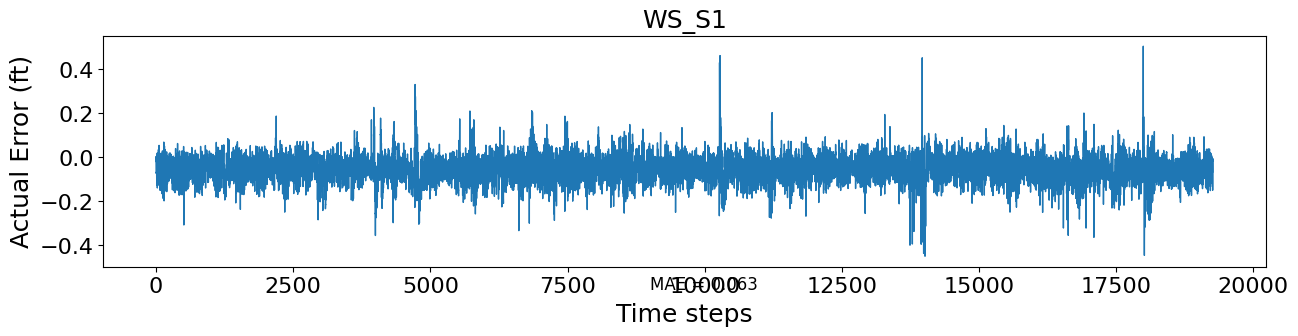

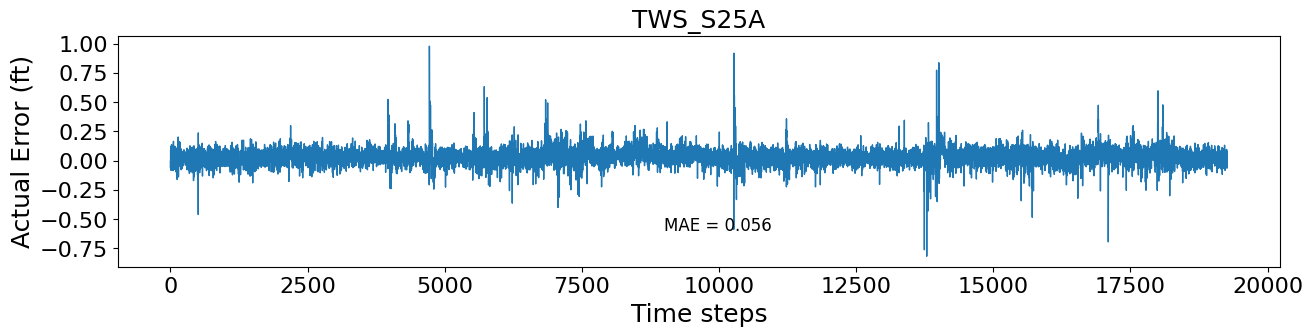

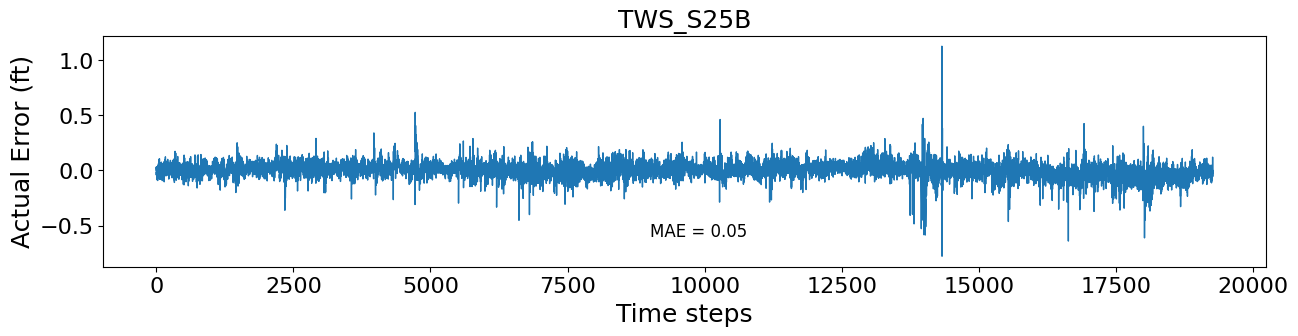

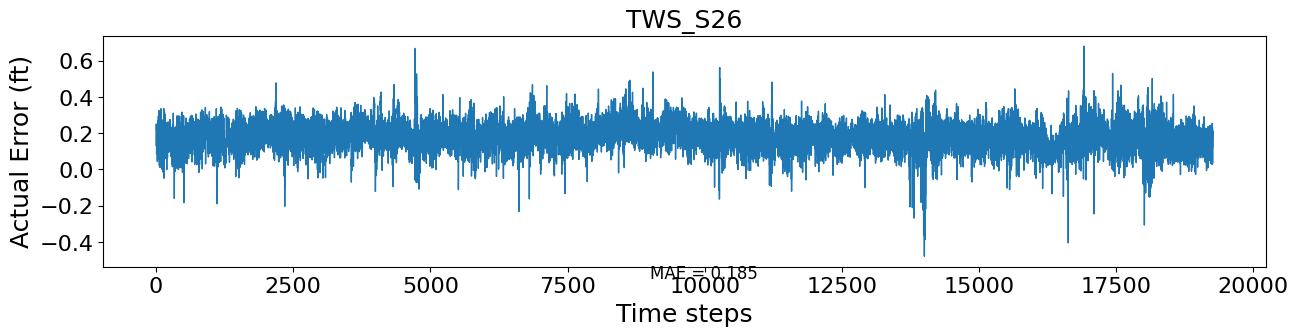

In [14]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [15]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
1
(19268,)
27
(19268,)
15
(19268,)
15


In [16]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
1
(19268,)
23
(19268,)
3
(19268,)
15


In [17]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
0
(19268,)
4
(19268,)
12
(19268,)
0
